In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import math

# load data
parts = pd.read_csv('Data/parts.csv')
sets = pd.read_csv('Data/sets.csv')
colors = pd.read_csv('Data/colors.csv')
inventories = pd.read_csv('Data/inventories.csv')
inventory_parts = pd.read_csv('Data/inventory_parts.csv')
minifigs = pd.read_csv('Data/minifigs.csv')
inventory_sets = pd.read_csv('Data/inventory_sets.csv')
inventory_minifigs = pd.read_csv('Data/inventory_minifigs.csv')
minifigures = pd.read_csv('Data/minifigs.csv')
categories = pd.read_csv('Data/part_categories.csv')
themes = pd.read_csv('Data/themes.csv')

In [40]:
##### find the final parent of a theme and make a dict ####
final_parent = {}

parent_dict = dict(zip(themes['id'], themes['parent_id']))

def find_final_parent(id):
    parent = parent_dict[id]
    if math.isnan(parent):
        return int(id), themes.loc[themes['id'] == id, 'name'].iloc[0]
    else:
        return find_final_parent(parent)
    
final_parent_dict = {id: find_final_parent(id) for id in themes['id']}

print(final_parent_dict)

{1: (1, 'Technic'), 3: (1, 'Technic'), 4: (1, 'Technic'), 16: (1, 'Technic'), 17: (1, 'Technic'), 18: (1, 'Technic'), 19: (1, 'Technic'), 20: (1, 'Technic'), 21: (1, 'Technic'), 22: (22, 'Creator'), 23: (22, 'Creator'), 34: (34, 'Make & Create'), 35: (34, 'Make & Create'), 50: (50, 'Town'), 51: (50, 'Town'), 52: (52, 'City'), 53: (52, 'City'), 54: (52, 'City'), 55: (52, 'City'), 56: (52, 'City'), 57: (52, 'City'), 58: (52, 'City'), 59: (52, 'City'), 60: (52, 'City'), 61: (52, 'City'), 63: (52, 'City'), 64: (52, 'City'), 65: (52, 'City'), 66: (52, 'City'), 67: (50, 'Town'), 86: (50, 'Town'), 87: (50, 'Town'), 88: (50, 'Town'), 89: (50, 'Town'), 90: (50, 'Town'), 91: (50, 'Town'), 92: (50, 'Town'), 93: (50, 'Town'), 94: (50, 'Town'), 104: (50, 'Town'), 105: (50, 'Town'), 106: (50, 'Town'), 112: (112, 'Racers'), 114: (112, 'Racers'), 118: (112, 'Racers'), 122: (112, 'Racers'), 123: (112, 'Racers'), 126: (126, 'Space'), 127: (126, 'Space'), 128: (126, 'Space'), 129: (126, 'Space'), 130: (1

In [41]:
##### merge data  #####

# merge left side of data structure
# merge categories with parts
categories_with_parts = pd.merge(categories, parts, left_on='id', right_on='part_cat_id')
categories_with_parts.rename(columns={'name_x': 'category_name', 'name_y': 'part_name', 'id': 'category_id'}, inplace=True)
categories_with_parts.drop('part_cat_id', axis=1, inplace=True)

# merge categories and parts with inventory_parts
categories_with_parts_with_inventory_parts = pd.merge(categories_with_parts, inventory_parts, left_on='part_num', right_on='part_num')
categories_with_parts_with_inventory_parts.drop('img_url', axis=1, inplace=True)

# merge inventory_parts with colors
categories_with_parts_with_colors_inventory_parts = pd.merge(categories_with_parts_with_inventory_parts, colors, left_on='color_id', right_on='id')
categories_with_parts_with_colors_inventory_parts.drop('color_id', axis=1, inplace=True)
categories_with_parts_with_colors_inventory_parts.rename(columns={'id': 'color_id', 'name': 'color_name', 'quantity': 'part_quantity'}, inplace=True)
categories_with_parts_with_colors_inventory_parts.to_csv('Merged_Data/inventory_parts.csv', index=False)


# merge middle of data structure
# merge minifgures with inventory_minifgures
minifigures_with_inventory_minifgures = pd.merge(minifigs, inventory_minifigs, left_on='fig_num', right_on='fig_num')
minifigures_with_inventory_minifgures.rename(columns={'name': 'minifig_name', 'quantity': 'minifig_quantitiy'}, inplace=True)
minifigures_with_inventory_minifgures.drop('img_url', axis=1, inplace=True)
minifigures_with_inventory_minifgures.to_csv('Merged_Data/inventory_minifigs.csv', index=False)

# merge right side of data structure
# merge sets with themes
sets_with_themes = pd.merge(sets, themes, left_on='theme_id', right_on='id')
sets_with_themes.drop(['img_url','theme_id'], axis=1, inplace=True)
sets_with_themes.rename(columns={'name_x': 'set_name', 'id': 'theme_id', 'name_y': 'theme_name'}, inplace=True)

for index, row in sets_with_themes.iterrows():                                      # just use over themes
    row_theme = row['theme_id']
    sets_with_themes.at[index, 'theme_id'] =  final_parent_dict[row_theme][0]
    sets_with_themes.at[index, 'theme_name'] =  final_parent_dict[row_theme][1]

sets_with_themes.drop('parent_id', axis=1, inplace=True)

# sets_with_themes = sets_with_themes[sets_with_themes.num_parts != 0]                  # delete all things that has no Lego parts
theme_names = sets_with_themes['theme_name'].unique()                                   # print themes
for name in theme_names:
    print(name)
print(len(themes))
sets_with_themes.to_csv('Merged_Data/inventory_sets.csv', index=False)


"""
# merge sets and themes with inventory_sets
sets_with_themes_inventory_sets = pd.merge(sets_with_themes, inventory_sets, left_on='set_num', right_on='set_num')
sets_with_themes_inventory_sets.rename(columns={'quantity': 'set_quantity'}, inplace=True)
sets_with_themes_inventory_sets.info()
sets_with_themes_inventory_sets.to_csv('Merged_Data/inventory_sets.csv', index=False)
"""

# merge all together
sets_with_inventory = pd.merge(sets_with_themes, inventories, left_on='set_num', right_on='set_num')

parts_with_inventory = pd.merge(categories_with_parts_with_colors_inventory_parts, sets_with_inventory, left_on='inventory_id', right_on='id')
parts_with_inventory.drop('id', axis=1, inplace=True)
parts_with_inventory.rename(columns={'num_parts': 'number_of_parts'}, inplace=True)

minifigs_with_inventory = pd.merge(minifigures_with_inventory_minifgures, sets_with_inventory, left_on='inventory_id', right_on='id')
minifigs_with_inventory.drop('id', axis=1, inplace=True)
minifigs_with_inventory.rename(columns={'num_parts_x': 'number_of_minifig_parts', 'num_parts_y': 'number_of_parts'}, inplace=True)


# filter data for the full years
data_parts = parts_with_inventory[parts_with_inventory['year'] <= 2023]
data_minifigs = minifigs_with_inventory[minifigs_with_inventory['year'] <= 2023]


# save full data 
data_minifigs.to_csv('Merged_Data/data_minifigs.csv', index=False)
data_parts.to_csv('Merged_Data/data_parts.csv', index=False)


Technic
Town
Castle
Space
Books
System
Duplo
Icons
Service Packs
Creator
Universal Building Set
Gear
Educational and Dacta
Train
Bulk Bricks
Star Wars
Hobby Sets
Bionicle
Discovery
Pirates
Seasonal
Super Heroes Marvel
Clikits
LEGO Brand Store
Sports
Harry Potter
Model Team
City
Other
Modular Buildings
Factory
Monster Fighters
Legoland
The Hobbit and Lord of the Rings
Adventurers
Mindstorms
Classic
Promotional
Make & Create
Juniors
Toy Story
Disney
Gabby’s Dollhouse
Super Heroes DC
Aquazone
Ninja
Ninjago
Minitalia
Primo
LEGO Originals
Hero Factory
Racers
Fabuland
Jurassic World
Rock Raiders
Studios
Alpha Team
4 Juniors
Monkie Kid
Value Packs
Building Set with People
Boat
Freestyle
Time Cruisers
BrickLink Designer Program
Architecture
Indiana Jones
FIRST LEGO League
Atlantis
Prince of Persia
LEGO Exclusive
Master Builder Academy
LEGO Ideas and CUUSOO
Minecraft
Fusion
LEGO Art
Homemaker
Elves
Belville
Nexo Knights
Western
Universe
Games
Pharaoh's Quest
Friends
Disney Princess
Cars
Pirates

In [42]:
##### Analysis over the years #####

# calculate mean number of parts per year per set
data_parts['part_quantity'] = data_parts['part_quantity'].astype(int)  
grouped_parts = data_parts.groupby(['set_num', 'year'])['part_quantity'].sum().reset_index()              # Sum part_quantity per set per year
mean_parts_per_set_per_year = grouped_parts.groupby('year')['part_quantity'].mean()                       # Calculate mean per year

print(mean_parts_per_set_per_year)

# calculate number of sets per year
grouped_sets = data_parts.groupby(['set_num', 'year']).size().reset_index(name='count')     # Count unique sets per year
sets_per_year = grouped_sets.groupby('year')['set_num'].count()                             # Calculate count per year

print(sets_per_year)

# calculate mean number of minifigs per year
data_minifigs['minifig_quantitiy'] = data_minifigs['minifig_quantitiy'].astype(int)
grouped_minifigs = data_minifigs.groupby(['set_num', 'year'])['minifig_quantitiy'].sum().reset_index() # Sum minifig_quantity per set per year
mean_minifigs_per_set_per_year = grouped_minifigs.groupby('year')['minifig_quantitiy'].mean()          # Calculate mean per year

print(mean_minifigs_per_set_per_year)

# calculate the mean number of colors per set
data_parts['year'] = pd.to_numeric(data_parts['year'], errors='coerce')
grouped_colors = data_parts.groupby(['set_num', 'year'])['color_id'].nunique().reset_index()            # Group by 'set_num' and 'year' and calculate the mean number of unique colors
mean_colors_per_set_per_year = grouped_colors.groupby('year')['color_id'].mean()                        # Calculate the mean number of colors per set per year

print(mean_colors_per_set_per_year)

# calculate number of colors per year
grouped_colors = data_parts.groupby(['color_id', 'year']).size().reset_index(name='count')    # Count unique colors per year
colors_per_year = grouped_colors.groupby('year')['color_id'].count()                          # Calculate count per year

print(colors_per_year)

# calculate mean number of unique parts per set per year
data_unique_parts = data_parts[data_parts['part_quantity'] == 1]                                            # Filter for parts with quantity 1
grouped_unique_parts = data_unique_parts.groupby(['set_num', 'year'])['part_num'].nunique().reset_index()   # Count unique parts per set per year
mean_unique_parts_per_set_per_year = grouped_unique_parts.groupby('year')['part_num'].mean()                # Calculate mean per year

print(mean_unique_parts_per_set_per_year)

# calculate the themes per year
grouped_themes = data_parts.groupby(['theme_id', 'year']).size().reset_index(name='count')    # Count unique themes per year
themes_per_year = grouped_themes.groupby('year')['theme_id'].count()                          # Calculate count per year

print(themes_per_year)

# calculate the mean number of categories per set
data_parts['year'] = pd.to_numeric(data_parts['year'], errors='coerce')
grouped_categories = data_parts.groupby(['set_num', 'year'])['category_id'].nunique().reset_index()     # Group by 'set_num' and 'year' and calculate the mean number of unique categories
mean_categories_per_set_per_year = grouped_categories.groupby('year')['category_id'].mean()             # Calculate the mean number of categories per set per year

print(mean_categories_per_set_per_year)

/var/folders/1z/94kl8yts6ls80stcsg7ld0lw0000gn/T/ipykernel_43950/3169895907.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_parts['part_quantity'] = data_parts['part_quantity'].astype(int)


year
1949    156.400000
1950      3.666667
1953     35.333333
1954     12.714286
1955     32.694444
           ...    
2019    310.211648
2020    344.904241
2021    410.123835
2022    418.008621
2023    419.798331
Name: part_quantity, Length: 73, dtype: float64
year
1949      5
1950      6
1953      3
1954     14
1955     36
       ... 
2019    704
2020    731
2021    751
2022    696
2023    719
Name: set_num, Length: 73, dtype: int64
year
1975    4.111111
1976    2.923077
1977    2.833333
1978    2.305556
1979    2.574468
1980    2.757576
1981    2.517241
1982    3.857143
1983    2.967742
1984    2.542857
1985    3.237288
1986    2.254902
1987    2.306122
1988    3.305556
1989    3.553191
1990    2.816327
1991    3.720000
1992    2.711538
1993    2.983051
1994    2.456140
1995    2.250000
1996    3.417722
1997    2.272727
1998    2.086420
1999    2.000000
2000    2.804511
2001    2.333333
2002    3.046512
2003    2.580952
2004    4.342857
2005    4.410256
2006    5.467391
2007    4.20

/var/folders/1z/94kl8yts6ls80stcsg7ld0lw0000gn/T/ipykernel_43950/3169895907.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_minifigs['minifig_quantitiy'] = data_minifigs['minifig_quantitiy'].astype(int)
/var/folders/1z/94kl8yts6ls80stcsg7ld0lw0000gn/T/ipykernel_43950/3169895907.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_parts['year'] = pd.to_numeric(data_parts['year'], errors='coerce')


year
1949     4.200000
1950     1.000000
1953     4.666667
1954     4.214286
1955     2.277778
          ...    
2019    12.430398
2020    12.830369
2021    13.215712
2022    14.125000
2023    15.463143
Name: color_id, Length: 73, dtype: float64
year
1949    10
1950     3
1953     5
1954     7
1955     7
        ..
2019    65
2020    74
2021    72
2022    75
2023    77
Name: color_id, Length: 73, dtype: int64
year
1949     1.000000
1950     1.000000
1953     1.000000
1954     2.071429
1955     4.888889
          ...    
2019    28.596237
2020    28.867872
2021    30.504749
2022    33.183792
2023    37.224576
Name: part_num, Length: 73, dtype: float64
year
1949     1
1950     1
1953     1
1954     1
1955     2
        ..
2019    42
2020    45
2021    44
2022    40
2023    43
Name: theme_id, Length: 73, dtype: int64


/var/folders/1z/94kl8yts6ls80stcsg7ld0lw0000gn/T/ipykernel_43950/3169895907.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_parts['year'] = pd.to_numeric(data_parts['year'], errors='coerce')


year
1949     1.600000
1950     1.000000
1953     1.000000
1954     1.214286
1955     1.583333
          ...    
2019    14.458807
2020    14.108071
2021    14.593875
2022    15.149425
2023    16.179416
Name: category_id, Length: 73, dtype: float64


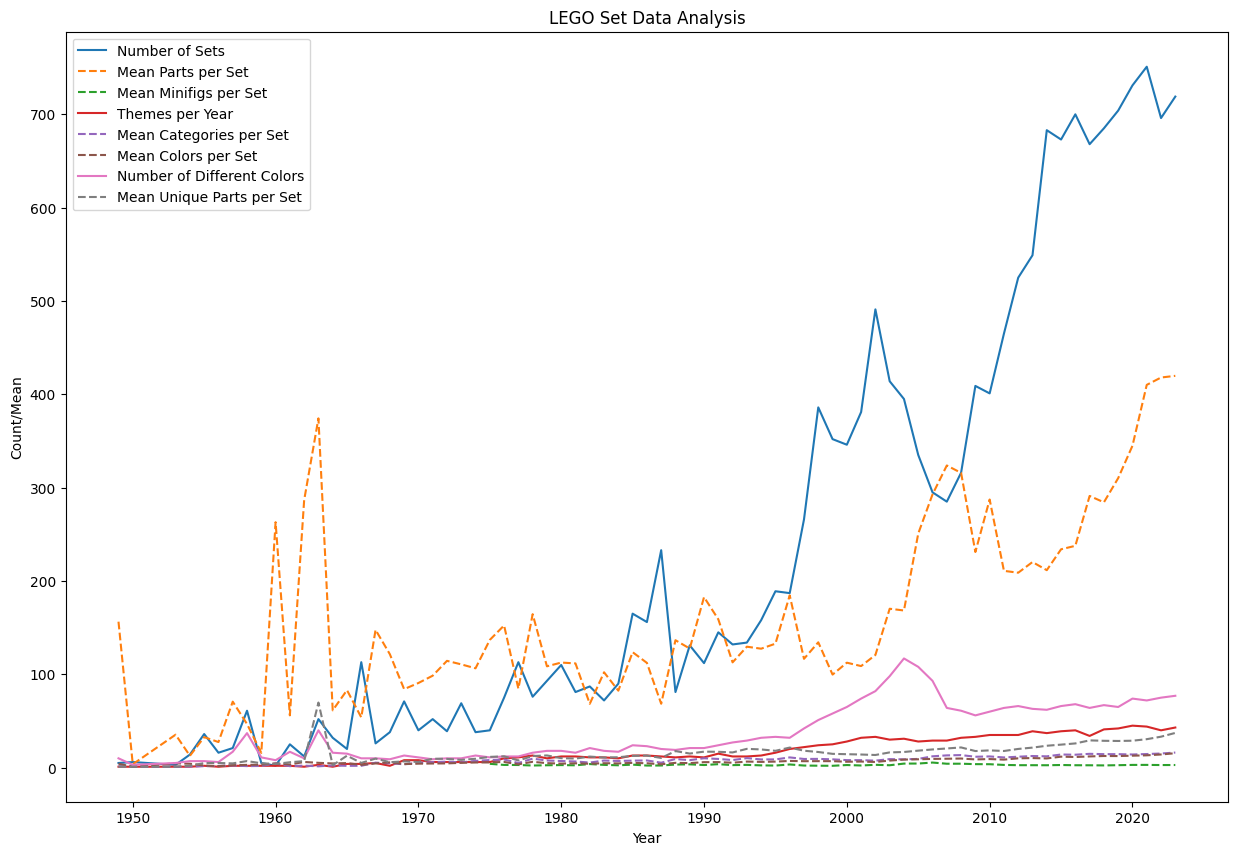

In [43]:
# Set up the plot for the analysis
plt.figure(figsize=(15, 10))

# Plot number of sets per year
plt.plot(sets_per_year.index, sets_per_year, label='Number of Sets')

# Plot mean number of parts per set per year
plt.plot(mean_parts_per_set_per_year.index, mean_parts_per_set_per_year, label='Mean Parts per Set', linestyle='--')

# Plot mean number of minifigs per set per year
plt.plot(mean_minifigs_per_set_per_year.index, mean_minifigs_per_set_per_year, label='Mean Minifigs per Set', linestyle='--')

# Plot themes per year
plt.plot(themes_per_year.index, themes_per_year, label='Themes per Year')

# Plot mean number of categories per set per year
plt.plot(mean_categories_per_set_per_year.index, mean_categories_per_set_per_year, label='Mean Categories per Set', linestyle='--')

# Plot mean number of colors per set per year
plt.plot(mean_colors_per_set_per_year.index, mean_colors_per_set_per_year, label='Mean Colors per Set', linestyle='--')

# Plot the number of colors per set per year
plt.plot(colors_per_year.index, colors_per_year, label='Number of Different Colors')

# Plot mean number of unique parts per set per year
plt.plot(mean_unique_parts_per_set_per_year.index, mean_unique_parts_per_set_per_year, label='Mean Unique Parts per Set', linestyle='--')


# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count/Mean')
plt.title('LEGO Set Data Analysis')
plt.legend()

# Show the plot
plt.show()

/var/folders/1z/94kl8yts6ls80stcsg7ld0lw0000gn/T/ipykernel_43950/25823476.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['part_quantity'] = df['part_quantity'].astype(int)  # Ensure part_quantity is integer
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


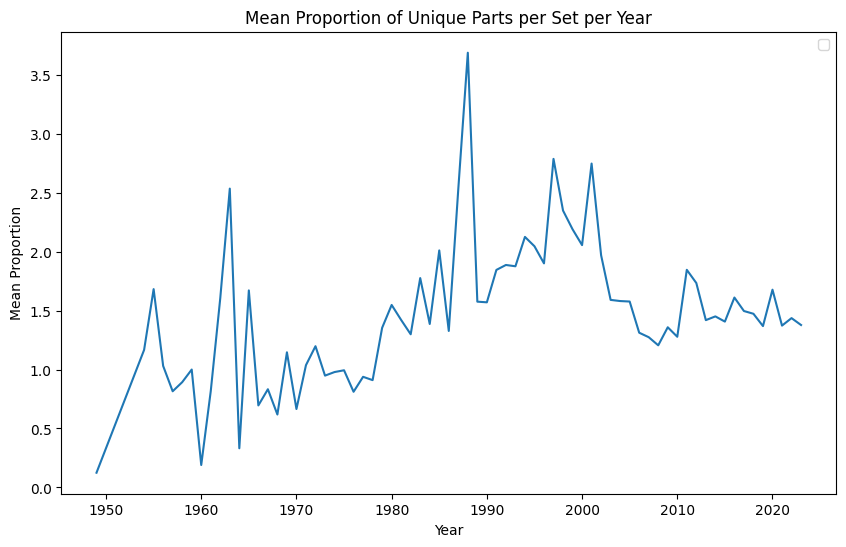

In [44]:
###### Plot the mean proportion of unique parts to not unique parts per set per year #####

def calculate_mean_proportion(df):
    df['part_quantity'] = df['part_quantity'].astype(int)  # Ensure part_quantity is integer

    # Calculate unique parts per set per year
    data_unique_parts = df[df['part_quantity'] == 1]
    unique_parts = data_unique_parts.groupby(['set_num', 'year'])['part_num'].nunique().reset_index()
    unique_parts.rename(columns={'part_num': 'unique_parts'}, inplace=True)

    # Calculate non-unique parts per set per year
    data_non_unique_parts = df[df['part_quantity'] > 1]
    non_unique_parts = data_non_unique_parts.groupby(['set_num', 'year'])['part_num'].nunique().reset_index()
    non_unique_parts.rename(columns={'part_num': 'non_unique_parts'}, inplace=True)

    # Merge the two dataframes
    data_proportion_parts = pd.merge(unique_parts, non_unique_parts, on=['set_num', 'year'])

    # Calculate the proportion
    data_proportion_parts['proportion'] = data_proportion_parts['unique_parts'] / data_proportion_parts['non_unique_parts']

    # Calculate the mean proportion for each year
    mean_proportion_per_year = data_proportion_parts.groupby('year')['proportion'].mean()

    return mean_proportion_per_year

def plot_mean_proportion(mean_proportion_per_year):
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(mean_proportion_per_year.index, mean_proportion_per_year)

    # Add title and labels
    plt.title('Mean Proportion of Unique Parts per Set per Year')
    plt.xlabel('Year')
    plt.ylabel('Mean Proportion')
    plt.legend()

    # Show the plot
    plt.show()

# Call the function with the result from 'calculate_mean_proportion'
mean_proportion_per_year = calculate_mean_proportion(data_parts)
plot_mean_proportion(mean_proportion_per_year)



In [45]:
##### find the different themes in the last 23 years #####

df_filtered = data_parts[(data_parts['year'] >= 2000) & (data_parts['year'] <= 2023)]       # Filter for years 2000 to 2023
theme_names_last_years = df_filtered['theme_name'].unique()                                 # Get unique themes per year

print(theme_names_last_years)           


['Pirates' 'City' 'Town' 'Castle' 'Educational and Dacta' 'Sports'
 'Creator' 'Modular Buildings' 'Games' 'Gear' 'Make & Create'
 'Designer Sets' 'Sculptures' 'BrickLink Designer Program' 'Harry Potter'
 'Super Mario' 'Star Wars' 'Ninjago' 'Seasonal' 'LEGO Ideas and CUUSOO'
 'Super Heroes Marvel' 'Disney' 'Avatar' 'Sonic The Hedgehog' 'Classic'
 'SpongeBob SquarePants' 'Cars' 'Toy Story' 'Studios' 'Super Heroes DC'
 'Legoland Parks' 'Racers' 'Inventor' 'Train' 'Juniors' 'Jurassic World'
 'FIRST LEGO League' 'Mixels' 'LEGO Brand Store' 'Exo-Force' 'Other'
 'The Hobbit and Lord of the Rings' 'LEGO Exclusive' 'X-Pod' 'Friends'
 'Disney Princess' 'Nexo Knights' 'Brickheadz' 'Indiana Jones' 'Factory'
 'Legends of Chima' 'Adventurers' 'The LEGO Movie' 'Trolls: World Tour'
 'Books' 'Promotional' 'Chinese Traditional Festivals' '4 Juniors'
 'Hidden Side' 'Icons' 'Space' 'Dimensions' 'Unikitty!' 'Fusion'
 'DC Super Hero Girls' 'Architecture' 'Minecraft' 'Brick Sketches'
 'Monkie Kid' 'Elves' 'D

theme_name  year
City        2004     1
            2005    23
            2006    20
            2007    21
            2008    32
                    ..
Technic     2019    14
            2020    14
            2021    16
            2022    16
            2023    18
Name: set_num, Length: 186, dtype: int64


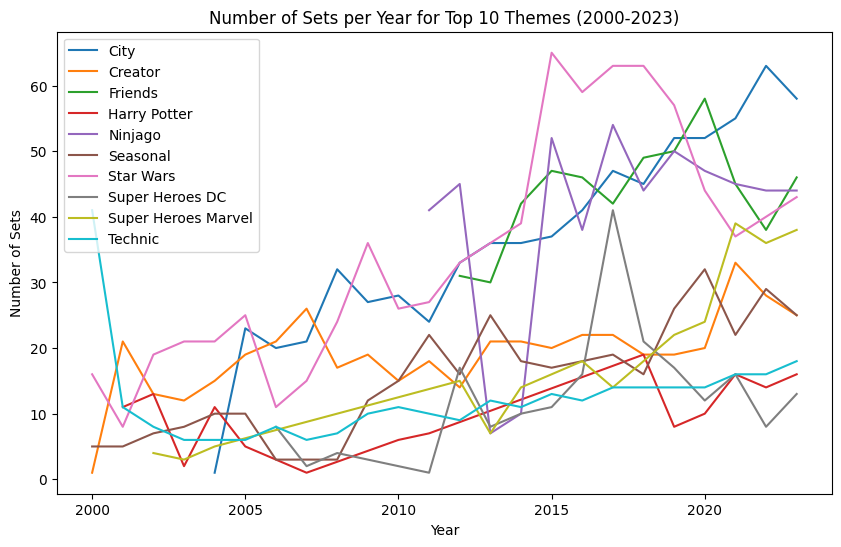

In [46]:
##### plot the top 10 themes over the years (2000 - 2023) #####

def plot_top_themes_and_sets(df):
    # Filter the DataFrame for the years 2000 to 2023
    df_filtered = df[(df['year'] >= 2000) & (df['year'] <= 2023)]

    # Find the top 10 themes
    grouped_themes = df_filtered.groupby(['theme_name', 'set_num']).size().reset_index(name='count')
    total_counts_per_theme = grouped_themes.groupby('theme_name')['count'].sum()
    top_10_themes = total_counts_per_theme.nlargest(10).index.tolist()

    # Filter the DataFrame for the top 10 themes
    df_top_themes = df_filtered[df_filtered['theme_name'].isin(top_10_themes)]

    # Group by 'theme_name' and 'year', and count distinct 'set_num'
    sets_per_year = df_top_themes.groupby(['theme_name', 'year'])['set_num'].nunique()
    print(sets_per_year)

    # Reset the index of the Series to use columns 'theme_name' and 'year' in the plot
    sets_per_year_reset = sets_per_year.reset_index()

    # Create the plot
    plt.figure(figsize=(10, 6))
    for theme in sets_per_year_reset['theme_name'].unique():
        data = sets_per_year_reset[sets_per_year_reset['theme_name'] == theme]
        plt.plot(data['year'], data['set_num'], label=theme)

    # Add title and labels
    plt.title('Number of Sets per Year for Top 10 Themes (2000-2023)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()

    # Show the plot
    plt.show()

# Call the function
plot_top_themes_and_sets(data_parts)

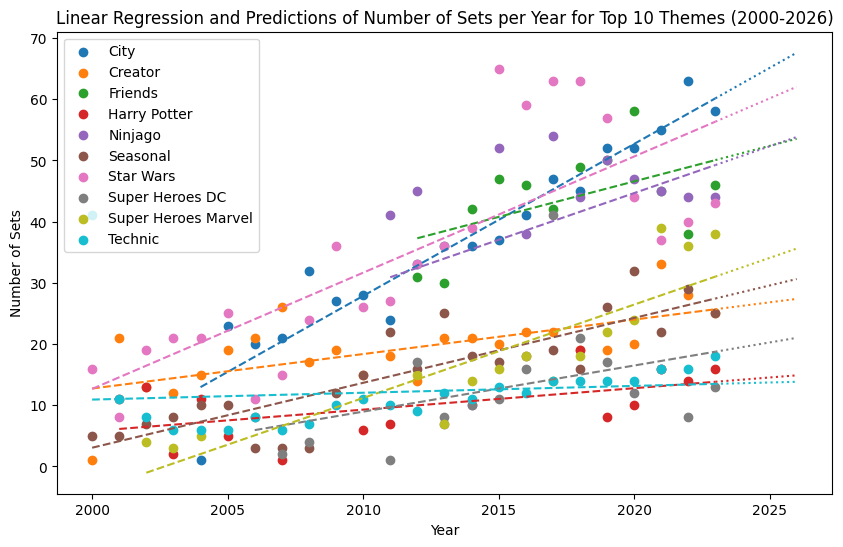

In [47]:
##### make a linear regression with a prediction for the next three years #####

def linear_regression_top_themes(df):
    # Filter the DataFrame for the years 2000 to 2023
    df_filtered = df[(df['year'] >= 2000) & (df['year'] <= 2023)]

    # Find the top 10 themes
    top_themes = df_filtered['theme_name'].value_counts().nlargest(10).index.tolist()

    # Filter the DataFrame for the top 10 themes
    df_top_themes = df_filtered[df_filtered['theme_name'].isin(top_themes)]

    # Group by 'theme_name' and 'year', and count distinct 'set_num'
    sets_per_year = df_top_themes.groupby(['theme_name', 'year'])['set_num'].nunique()

    # Reset the index of the Series to use columns 'theme_name' and 'year' in the plot
    sets_per_year_reset = sets_per_year.reset_index()

    # Create the plot
    plt.figure(figsize=(10, 6))
    for theme in sets_per_year_reset['theme_name'].unique():
        data = sets_per_year_reset[sets_per_year_reset['theme_name'] == theme]
        x = data['year'].values.reshape(-1, 1)
        y = data['set_num'].values
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        plt.scatter(x, y, label=theme)
        plt.plot(x, y_pred, linestyle='--')

        # Make predictions until 2026
        x_future = np.arange(2023, 2027).reshape(-1, 1)
        y_future_pred = model.predict(x_future)
        plt.plot(x_future, y_future_pred, linestyle=':', color=plt.gca().lines[-1].get_color())

    # Add title and labels
    plt.title('Linear Regression and Predictions of Number of Sets per Year for Top 10 Themes (2000-2026)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()

    # Show the plot
    plt.show()

# Call the function
linear_regression_top_themes(data_parts)

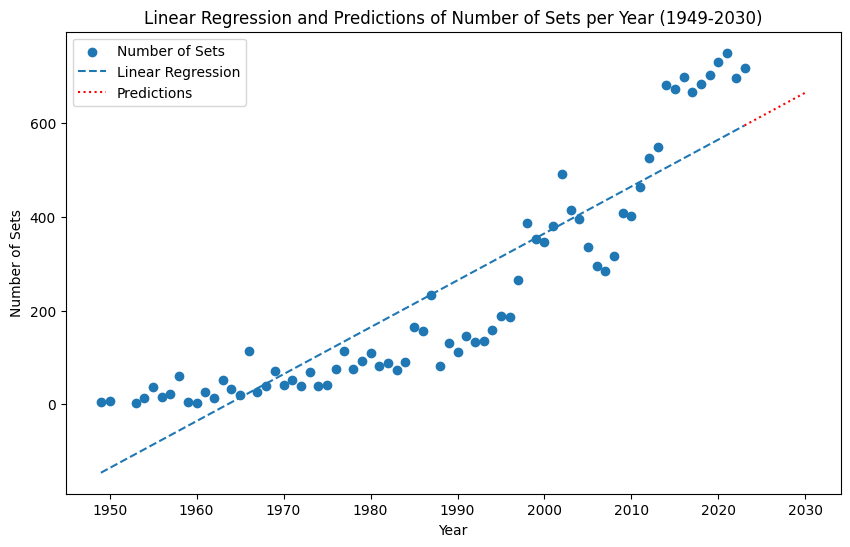

In [48]:
##### make a linear regression for the number of sets with prediction until 2030 #####

def linear_regression_sets(df):
    # Group by 'year', and count distinct 'set_num'
    sets_per_year = df.groupby('year')['set_num'].nunique()

    # Reset the index of the Series to use column 'year' in the plot
    sets_per_year_reset = sets_per_year.reset_index()

    # Create the plot
    plt.figure(figsize=(10, 6))
    x = sets_per_year_reset['year'].values.reshape(-1, 1)
    y = sets_per_year_reset['set_num'].values
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    plt.scatter(x, y, label='Number of Sets')
    plt.plot(x, y_pred, linestyle='--', label='Linear Regression')

    # Make predictions until 2030
    x_future = np.arange(2023, 2031).reshape(-1, 1)
    y_future_pred = model.predict(x_future)
    plt.plot(x_future, y_future_pred, linestyle=':', color='red', label='Predictions')

    # Add title and labels
    plt.title('Linear Regression and Predictions of Number of Sets per Year (1949-2030)')
    plt.xlabel('Year')
    plt.ylabel('Number of Sets')
    plt.legend()

    # Show the plot
    plt.show()

# Call the function
linear_regression_sets(data_parts)


/var/folders/1z/94kl8yts6ls80stcsg7ld0lw0000gn/T/ipykernel_43950/3046605247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['part_quantity'] = df['part_quantity'].astype(int)


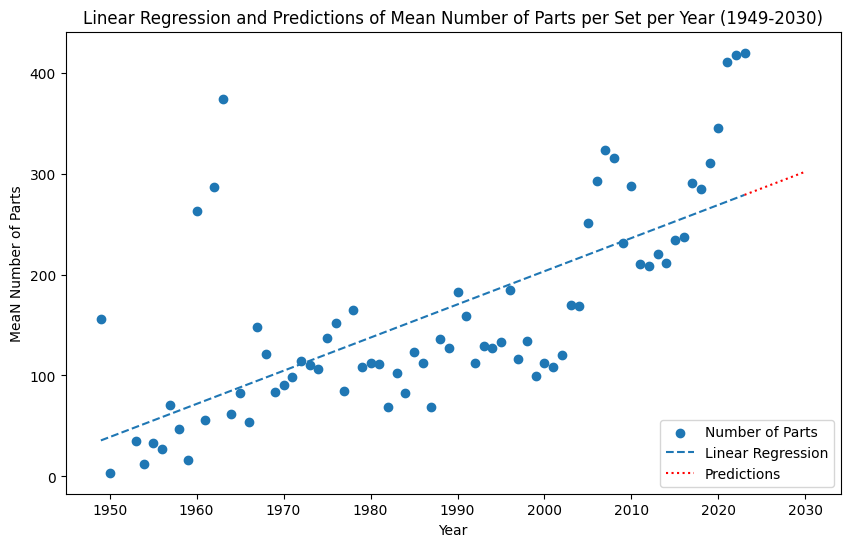

In [49]:
##### make a linear regression for the mean parts per set per year with prediction until 2030 #####

def linear_regression_parts(df):
    df['part_quantity'] = df['part_quantity'].astype(int)  
    grouped_parts = df.groupby(['set_num', 'year'])['part_quantity'].sum().reset_index()                        # Sum part_quantity per set per year
    mean_parts_per_set_per_year = grouped_parts.groupby('year')['part_quantity'].mean().reset_index()           # Calculate mean per year

    # Create the plot
    plt.figure(figsize=(10, 6))
    x = mean_parts_per_set_per_year['year'].values.reshape(-1, 1)
    y = mean_parts_per_set_per_year['part_quantity'].values
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    plt.scatter(x, y, label='Number of Parts')
    plt.plot(x, y_pred, linestyle='--', label='Linear Regression')

    # Make predictions until 2030
    x_future = np.arange(2023, 2031).reshape(-1, 1)
    y_future_pred = model.predict(x_future)
    plt.plot(x_future, y_future_pred, linestyle=':', color='red', label='Predictions')

    # Add title and labels
    plt.title('Linear Regression and Predictions of Mean Number of Parts per Set per Year (1949-2030)')
    plt.xlabel('Year')
    plt.ylabel('MeaN Number of Parts')
    plt.legend()

    # Show the plot
    plt.show()

# Call the function with
linear_regression_parts(data_parts)


In [50]:
##### General Information about data set ####

number_of_sets =data_parts['set_num'].nunique()
print(f'Number of Sets: {number_of_sets}')
number_of_parts = data_parts['part_num'].nunique()
print(f'Number of Parts: {number_of_parts}')
number_of_minifigs = data_minifigs['fig_num'].nunique()
print(f'Number of Minifigures: {number_of_minifigs}')
number_of_themes = data_parts['theme_name'].nunique()
print(f'Number of Themes: {number_of_themes}')
number_of_colors = data_parts['color_id'].nunique()
print(f'Numer of Colors: {number_of_colors}')
number_of_categories = data_parts['category_id'].nunique()
print(f'Numer of Categories: {number_of_categories}')




Number of Sets: 17077
Number of Parts: 35408
Number of Minifigures: 13546
Number of Themes: 144
Numer of Colors: 251
Numer of Categories: 66
